Минимальный напор: 25.627982059915496


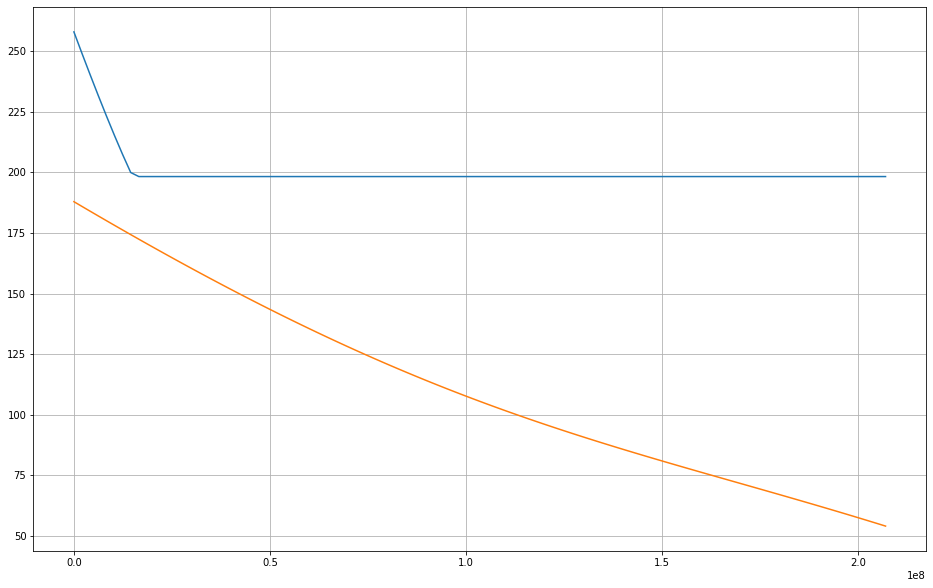

24331.7330398214 1761.907903268271
23922.22030260131 1767.405823310805
23547.23041337996 1773.0845226956449
23202.01692968185 1778.9578246817948
22882.72610115919 1785.0373723400287
22586.189353611655 1791.3334055363412
22309.77226763787 1797.8552134597392
22051.26264212125 1804.6114096979754
21808.786164442918 1811.6101036773064
21580.741944256264 1818.8590080632343
21365.752578910095 1826.365504518474
21162.62501053978 1834.1366810390314
20970.319507277974 1842.179348949021
20787.92483682878 1850.5000446297959
20614.63821394875 1859.105019243076
20449.74896942336 1868.0002184347416
20292.625134109298 1877.191254116619
20142.702358259376 1886.6833680289965
19999.474687039703 1896.4813883455975
19862.486822129507 1906.5896805883865
19731.32761063872 1917.012091775931
19605.624526483352 1927.7518888116297
19485.038970378835 1938.8116912106257
19369.262247795326 1950.1933983731324
19258.012111241584 1961.8981116714185
19151.029774862516 1973.9260516674497
19048.07732634346 1986.276470851

In [5]:
#Расчёт конденсатора кожухотрубного
import matplotlib.pyplot as pt
import numpy as n
from CoolProp.CoolProp import PropsSI as p
from scipy.optimize import root
import math as m

#Исходные данные:
G1 = 98.7
T11 = 258
Q1end=0
G2 = 758
T21 = 54
P11=1500000
P22=18000000

##############################################
CO2  = 'REFPROP::CO2'
H2O  = 'REFPROP::WATER'

H11  = p('H','T', T11+273.15, 'P', P11, H2O)
H12  = p('H','P', P11, 'Q', Q1end, H2O)
H21  = p('H','T', T21+273.15, 'P', P22, CO2)

#Разбиение по энтальпии:
s    = 100 #Кол-во шагов
step = (H11-H12)/(s) 

#Нулевые массивы:
t1   = n.zeros(s+1)
t2   = n.zeros(s+1)
Q    = n.zeros(s+1)
t1av = n.zeros(s)
t2av = n.zeros(s)
ro1 = n.zeros(s)
ro2 = n.zeros(s)
nu1 = n.zeros(s)
nu2 = n.zeros(s)
lambda1 = n.zeros(s)
lambda2 = n.zeros(s)
Pr1 = n.zeros(s)
Pr2 = n.zeros(s)
DTav = n.zeros(s)
w1 = n.zeros(s)
w2= n.zeros(s)
Re1= n.zeros(s)
Re2= n.zeros(s)
Nu1= n.zeros(s)
Nu2= n.zeros(s)
f1= n.zeros(s)
f2= n.zeros(s)
fNu1= n.zeros(s)
fNu2= n.zeros(s)
alpha1= n.zeros(s)
alpha2= n.zeros(s)
K= n.zeros(s)
F= n.zeros(s+1)
L= n.zeros(s+1)
P2= n.zeros(s+1)
tw2 = n.zeros(s+1)

#Противоток:
h11 = H11
i=0
for i in range(s+1):
    t1[i] = p('T','H', h11, 'P', P11, H2O)-273.15 
    h12 = h11 - step
    dQ = G1 * (h11-h12)
    if i < s:
        Q[i+1]=Q[i]+dQ
    h11 = h12
h21 = H21
i=0
for i in range(s+1):
    t2[s-i] = p('T','H', h21, 'P', P22, CO2)-273.15  
    h22 = h21+((Q[s-i]-Q[s-i-1])/G2)
    h21 = h22
DT=t1-t2
#Определение индекса начала конденсации:
for i in range(s):
    if round(t1[i],5)==round(t1[i+1],5):
        icond=i
        break;
print('Минимальный напор:',min(DT))
x  = [Q[i] for i in range(s+1)]  
y1 = [t1[i] for i in (range(s+1))]
y2 = [t2[i] for i in (range(s+1))]
pt.figure(figsize=(16, 10))
pt.plot(x, y1,x,y2)
pt.grid(True)
pt.show()

#Геометрия:
Dvnes = 0.017 #Внешний диаметр трубки https://docs.cntd.ru/document/1200001411
DeltaTube = 0.0022
DeltaKorp = 0.02
Dvnut = Dvnes-2*DeltaTube
steptube = Dvnes*1.2
lambdaw = 20
delta = 10**-5 #Шероховатость
dh1 = Dvnes
dh2 = Dvnut

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
w2out=1
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

#Количество труб по диаметру:
roout2 = p('D','T', t2[s]+273.15, 'P', P22, CO2)
Fproh2 = G2/(w2out*roout2)

Ntubes = m.ceil(Fproh2/((n.pi*Dvnut**2)/4))

summ = 0
nd=0
n2 = 0
while n2 < Ntubes:
    summ = summ + nd
    n2=1+6*summ
    nd=nd+1
nd = 1+2*(nd-1)
Ntubes = n2
Dkorp = nd*steptube+2*Dvnes
Fproh1 = ((n.pi*Dkorp**2)/4)-(Ntubes*(n.pi*Dvnes**2)/4)
Fl = n.pi*((Dvnes+Dvnut)/2)*Ntubes

P2[0]=P22
#Зона охлаждения:
for i in range(icond):
    #Свойства
    t1av[i]   =(t1[i]+t1[i+1])/2
    t2av[i]   =(t2[i]+t2[i+1])/2
    ro1[i]    =p('D','T', t1av[i]+273.15, 'P', P11, H2O)
    ro2[i]    =p('D','T', t2av[i]+273.15, 'P', P22, CO2)
    nu1[i]    =p('V','T', t1av[i]+273.15, 'P', P11, H2O)/ro1[i]
    nu2[i]    =p('V','T', t2av[i]+273.15, 'P', P22, CO2)/ro2[i]
    lambda1[i]=p('L','T', t1av[i]+273.15, 'P', P11, H2O)
    lambda2[i]=p('L','T', t2av[i]+273.15, 'P', P22, CO2)
    Pr1[i]    =p('PRANDTL','T', t1av[i]+273.15, 'P', P11, H2O)
    Pr2[i]    =p('PRANDTL','T', t2av[i]+273.15, 'P', P22, CO2)
    DTav[i]   =t1av[i]-t2av[i]
    w1[i] = G1/(ro1[i]*Fproh1)
    w2[i] = G2/(ro2[i]*Fproh2)
    Re1[i] = w1[i]*dh1/nu1[i]
    Re2[i] = w2[i]*dh2/nu2[i]
    Nu2[i] = 0.021*Re2[i]**0.8*Pr2[i]**0.43
    def func(x):
        delta = 10**-5
        left = x
        right = 1/(2*n.log10((2.51/(Re2[i]*(x)**(1/2)))+(delta/3.7)))**2
        return left-right
    sol = root(func, 0.01)
    f2[i]=float(sol.x)
    alpha2[i] = Nu2[i]*lambda2[i]/dh2
    w1[i] = G1/(ro1[i]*Fproh1)
    Re1[i] = w1[i]*Dvnes/nu1[i]
    Nu1[i] = 0.22*(Re1[i]**0.65)*(Pr1[i]**0.36)
    alpha1[i] = Nu1[i]*lambda1[i]/dh1
    K[i] = 1/((1/alpha1[i])+(1/alpha2[i])+((((Dvnes+Dvnut)/2)/(2*lambdaw))*(n.log(Dvnes/Dvnut))))
    dF = (Q[i+1]-Q[i])/(K[i]*DTav[i])
    dL = dF/Fl
    if i < s:
        F[i+1]=F[i]+dF
    if i < s:
        L[i+1]=L[i]+dL
    dP2 = f2[i]*dL/dh2*ro2[i]*w2[i]**2/2
    if i < s:
        P2[i+1]=P2[i]-dP2
#Зона конденсации:
for i in range(icond,s):
    t1av[i]   =(t1[i]+t1[i+1])/2
    t2av[i]   =(t2[i]+t2[i+1])/2
    ro1[i]    =p('D','T', t1av[i]+273.15, 'P', P11, H2O)
    ro2[i]    =p('D','T', t2av[i]+273.15, 'P', P22, CO2)
    nu1[i]    =p('V','T', t1av[i]+273.15, 'P', P11, H2O)/ro1[i]
    nu2[i]    =p('V','T', t2av[i]+273.15, 'P', P22, CO2)/ro2[i]
    lambda1[i]=p('L','T', t1av[i]+273.15, 'P', P11, H2O)
    lambda2[i]=p('L','T', t2av[i]+273.15, 'P', P22, CO2)
    Pr1[i]    =p('PRANDTL','T', t1av[i]+273.15, 'P', P11, H2O)
    Pr2[i]    =p('PRANDTL','T', t2av[i]+273.15, 'P', P22, CO2)
    DTav[i]   =t1av[i]-t2av[i]
    w2[i] = G2/(ro2[i]*Fproh2)
    Re2[i] = w2[i]*dh2/nu2[i]
    Nu2[i] = 0.021*Re2[i]**0.8*Pr2[i]**0.43
    def func(x):
        delta = 10**-5
        left = x
        right = 1/(2*n.log10((2.51/(Re2[i]*(x)**(1/2)))+(delta/3.7)))**2
        return left-right
    sol = root(func, 0.01)
    f2[i]=float(sol.x)
    alpha2[i] = Nu2[i]*lambda2[i]/dh2
    lambdal = p('L','T', t1av[icond]+273.15, 'Q', 0, H2O)
    rol=p('D','T', t1av[icond]+273.15, 'Q', 0, H2O)
    rov=p('D','T', t1av[icond]+273.15, 'Q', 1, H2O)
    mul=p('V','T', t1av[icond]+273.15, 'Q', 0, H2O)
    cpl = p('CPMASS','T', t1av[icond]+273.15, 'Q', 0, H2O)
    h = (p('H','P', P11, 'Q', 1, H2O)-p('H','P', P11, 'Q', 0, H2O))*1000
    #tw2[i] = ((Q[i+1]-Q[i])*((((Dvnes+Dvnut)/2)/(2*lambdaw))*(n.log(Dvnes/Dvnut))))+t2av[i]+((Q[i+1]-Q[i])/alpha2[i])
    hfg = h+0.68*cpl*(t1[icond]-tw2[i])
    tw2[i] = (t2av[i]+t1[icond])/2  #пока приближение
    alpha1[i] = 0.729*((9.81*rol*(rol-rov)*hfg*(lambdal**3)/(mul*(t1[icond]-tw2[i])*Dvnes*(nd)))**(1/4))
    K[i] = 1/((1/alpha1[i])+(1/alpha2[i])+((((Dvnes+Dvnut)/2)/(2*lambdaw))*(n.log(Dvnes/Dvnut))))
    dF = (Q[i+1]-Q[i])/(K[i]*DTav[i])
    dL = dF/Fl
    print(alpha1[i],alpha2[i])
    if i < s:
        F[i+1]=F[i]+dF
    if i < s:
        L[i+1]=L[i]+dL
    dP2 = f2[i]*dL/dh2*ro2[i]*w2[i]**2/2
    if i < s:
        P2[i+1]=P2[i]-dP2
DP = P2[0]-P2[s]
print('Площадь,','Длина,','Диаметр корпуса',', Потери по холодному')
print(F[s],L[s],Dkorp,DP)